# Bag of Words to classify articles

## 1. Getting all the packages

In [80]:
# Getting all the imports
import numpy as np
import pandas as pd
import nltk

from sklearn.metrics import classification_report
import json
import itertools
from statistics import mean
import re
import string
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [36]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def load_file():
    with open('./data/arxiv-metadata-oai-snapshot.json') as f:
        for line in f:
            yield json.loads(line)


./data\arxiv-metadata-oai-snapshot.json


## 2. Exploratory Data Analysis

In [37]:
metadata = load_file()

subset = itertools.islice(metadata, 100000)

df = pd.DataFrame(subset)
df.head(5)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              100000 non-null  object
 1   submitter       100000 non-null  object
 2   authors         100000 non-null  object
 3   title           100000 non-null  object
 4   comments        87342 non-null   object
 5   journal-ref     50663 non-null   object
 6   doi             61265 non-null   object
 7   report-no       9464 non-null    object
 8   categories      100000 non-null  object
 9   license         56755 non-null   object
 10  abstract        100000 non-null  object
 11  versions        100000 non-null  object
 12  update_date     100000 non-null  object
 13  authors_parsed  100000 non-null  object
dtypes: object(14)
memory usage: 10.7+ MB


Let's check what's the value count of each unique element in the 'categories' column

In [39]:
val_count = df.categories.value_counts()
val_count.head(10)

astro-ph             16268
hep-ph                5326
quant-ph              4228
hep-th                3706
cond-mat.mtrl-sci     2083
gr-qc                 1953
cond-mat.mes-hall     1709
hep-ex                1517
cond-mat.str-el       1504
nucl-th               1351
Name: categories, dtype: int64

In [40]:
val_count.tail(10)

stat.AP physics.class-ph                              1
cond-mat.quant-gas                                    1
math.AG math.CV math.DS math.GT                       1
q-bio.NC cond-mat.dis-nn nlin.CD                      1
cond-mat.mtrl-sci cond-mat.mes-hall physics.app-ph    1
cs.IR cs.CL cs.CY                                     1
cs.NE cs.AI cs.CY                                     1
cond-mat.mtrl-sci cond-mat.stat-mech stat.AP          1
hep-ph cond-mat.stat-mech hep-th nucl-th              1
astro-ph math.DS nlin.CD                              1
Name: categories, dtype: int64

In [41]:
df.categories.nunique()

6066

That is a total of 6066 categories in this data! We will narrow it down to let's say 5 categories for now since it seems like there are a lot of subcategories

In [42]:
df_cat = df[df['categories'].isin(['hep-ph', 'quant-ph', 'astro-ph', 'hep-th', 'gr-qc', 'cond-mat.mtrl-sci'])] # high energy physics/quantum physics
df_cat['categories'].value_counts()

astro-ph             16268
hep-ph                5326
quant-ph              4228
hep-th                3706
cond-mat.mtrl-sci     2083
gr-qc                 1953
Name: categories, dtype: int64

In [43]:
df_cat = pd.get_dummies(df_cat, columns=['categories'])

In [44]:
X = df_cat['abstract']

# Dependent Variables
y = df_cat[['categories_astro-ph', 'categories_gr-qc',
       'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph', 'categories_cond-mat.mtrl-sci']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


## 3. Creating bag of words using CountVectorizer

Bag of Words creates a set of vectors containing the count of word occurrences in the document (abstracts in this case)

In [91]:
stop_words = _stop_words.ENGLISH_STOP_WORDS
# stop_words = nltk.corpus.stopwords.words()

# Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

vect = CountVectorizer(max_features=1000, preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

print(X_train_dtm.shape, X_test_dtm.shape)

(23494, 1000) (10070, 1000)


## 4. Data Modeling

To classify the articles, Naive Bayes, Logistic Regression and Random Forest are used to compare and contrast the difference in terms of classification performance.

In [92]:
def calculate_roc_auc(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [96]:
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, y_train)

lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=3000)) \
                    .fit(X_train_dtm, y_train)

rf = MultiOutputClassifier(RandomForestClassifier()).fit(X_train_dtm, y_train)

In [97]:
# Creating an empty list of results
results = []
# Making predictions from all the trained models and measure performance for each
for model in [nb, lr, rf]:
    # Extracting name of the model
    est = type(model.estimator).__name__
    # Actual output variables
    y_vals = y_test.to_numpy()
    # Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_test_dtm))[:, :, 1])
    # Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals, y_preds))
    
    y_preds_2 = np.argmax(y_preds, axis=1)
    y_test_2 = np.argmax(y_vals, axis=1)
    print(f"The Classification report for {est}: \n")
    print(classification_report(y_preds_2, y_test_2))   
    # Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])


The Classification report for MultinomialNB: 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4633
           1       0.69      0.60      0.64       717
           2       0.89      0.91      0.90      1564
           3       0.83      0.75      0.79      1226
           4       0.87      0.88      0.88      1238
           5       0.85      0.80      0.82       692

    accuracy                           0.89     10070
   macro avg       0.84      0.82      0.83     10070
weighted avg       0.88      0.89      0.89     10070

The Classification report for LogisticRegression: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4700
           1       0.70      0.62      0.66       693
           2       0.89      0.89      0.89      1598
           3       0.79      0.77      0.78      1140
           4       0.89      0.86      0.87      1284
           5       0.84      0.85

In [98]:
# Output the results as a table
pd.DataFrame(results, columns=["Model", "Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.971300
1,LogisticRegression,0.979965
2,RandomForestClassifier,0.965166


Let's check the important words for each class

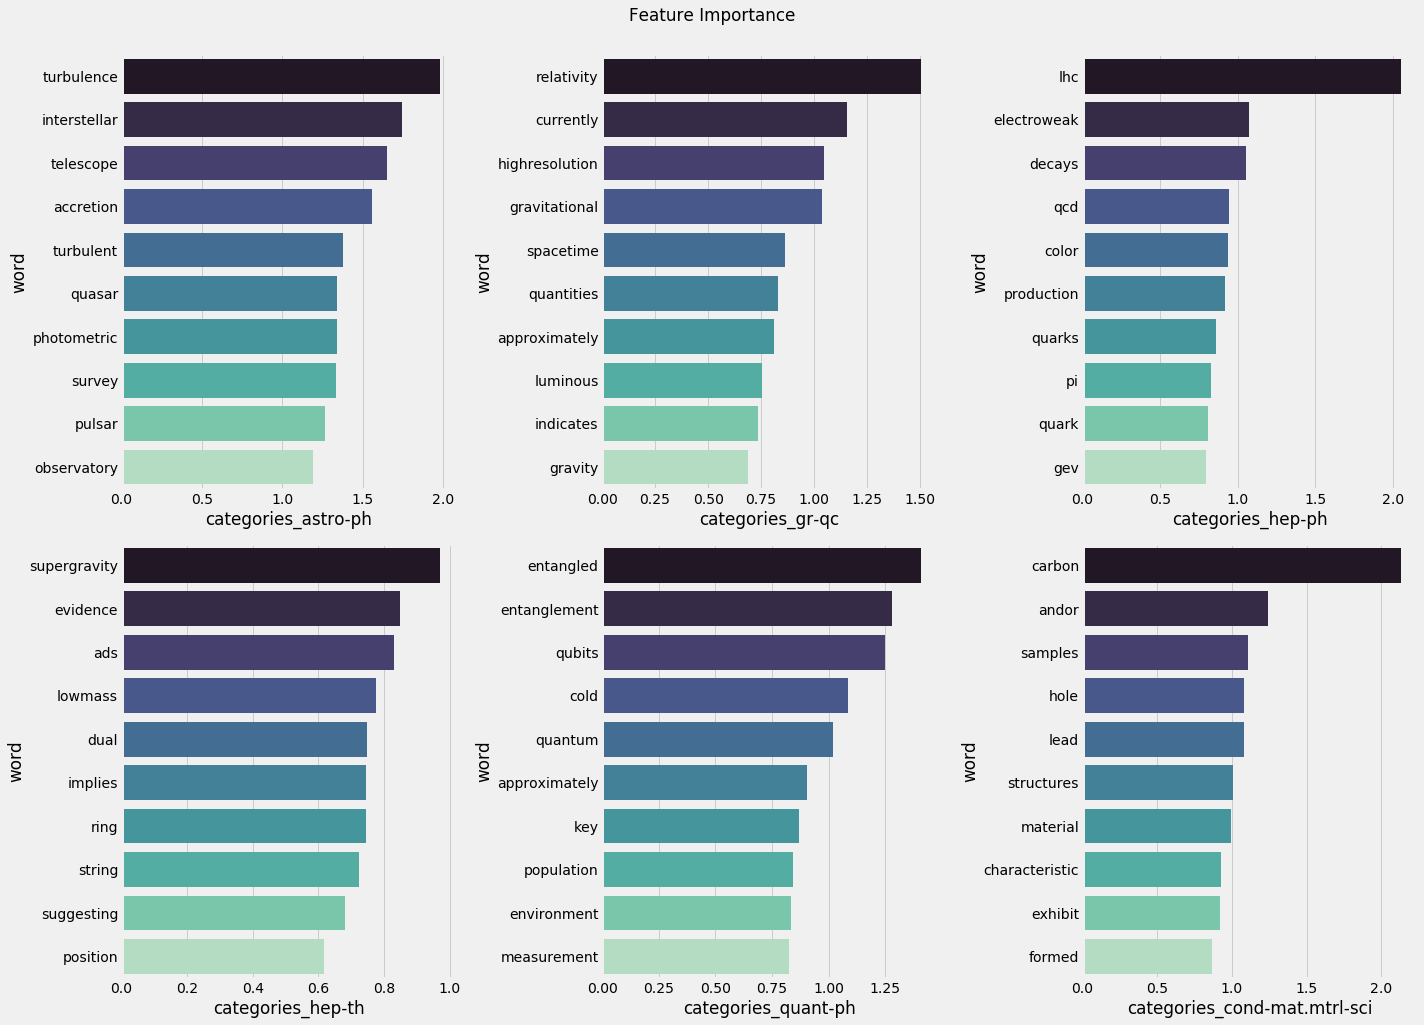

In [99]:
# Assigning the feature names to an empty list
feat_impts = [vect.get_feature_names()]

# For all the models save the feature importances in the list.estimators_ would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())

y_cols = ['categories_astro-ph', 'categories_gr-qc', 'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph', 'categories_cond-mat.mtrl-sci']

# Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns = ['word', 'categories_astro-ph', 'categories_gr-qc',
       'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph', 'categories_cond-mat.mtrl-sci'])
#Converting Feature Importance Columns from string to float
df_feats_impts[y_cols] = df_feats_impts[y_cols].astype("float32")
df_feats_impts.head()

#Creating Individual Feature Importance table by sorting on specific toxic-type column and selecting top 5 words
astro_fi = df_feats_impts[["word","categories_astro-ph"]].sort_values(by = "categories_astro-ph", ascending = False).head(10)
gr_fi = df_feats_impts[["word","categories_gr-qc"]].sort_values(by = "categories_gr-qc", ascending = False).head(10)
hep_ph_fi = df_feats_impts[["word","categories_hep-ph"]].sort_values(by = "categories_hep-ph", ascending = False).head(10)
hep_th_fi = df_feats_impts[["word","categories_hep-th"]].sort_values(by = "categories_hep-th", ascending = False).head(10)
quant_fi = df_feats_impts[["word","categories_quant-ph"]].sort_values(by = "categories_quant-ph", ascending = False).head(10)
math_fi = df_feats_impts[["word","categories_cond-mat.mtrl-sci"]].sort_values(by = "categories_cond-mat.mtrl-sci", ascending = False).head(10)

plt.style.use('fivethirtyeight') 

#Plotting top 5 words based on coefficient values from the LR model
fig,(ax1, ax2) = plt.subplots(2,3,figsize=(20,15))
sns.barplot(x = "categories_astro-ph", y = "word", ax = ax1[0], data = astro_fi,  palette = 'mako')
sns.barplot(x = "categories_gr-qc", y = "word", ax = ax1[1], data = gr_fi, palette = 'mako')
sns.barplot(x = "categories_hep-ph", y = "word", ax = ax1[2], data = hep_ph_fi, palette = 'mako')
sns.barplot(x = "categories_hep-th", y = "word", ax = ax2[0], data = hep_th_fi, palette = 'mako')
sns.barplot(x = "categories_quant-ph", y = "word", ax = ax2[1], data = quant_fi, palette = 'mako')
sns.barplot(x = "categories_cond-mat.mtrl-sci", y = "word", ax = ax2[2], data = math_fi, palette = 'mako')
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


What if we use TF-IDF instead of CountVectorizer?

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = _stop_words.ENGLISH_STOP_WORDS
# stop_words = nltk.corpus.stopwords.words()

# Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

vectorizer = TfidfVectorizer(max_features=1000, preprocessor=clean)
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.fit_transform(X_test)

print(X_train_dtm.shape, X_test_dtm.shape)

(23494, 1000) (10070, 1000)


In [76]:
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, y_train)

lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=3000)) \
                    .fit(X_train_dtm, y_train)

rf = MultiOutputClassifier(RandomForestClassifier()).fit(X_train_dtm, y_train)

In [77]:
# Creating an empty list of results
results = []
# Making predictions from all the trained models and measure performance for each
for model in [nb, lr, rf]:
    # Extracting name of the model
    est = type(model.estimator).__name__
    # Actual output variables
    y_vals = y_test.to_numpy()
    # Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_test_dtm))[:, :, 1])
    # Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals, y_preds))
    
    y_preds_2 = np.argmax(y_preds, axis=1)
    y_test_2 = np.argmax(y_vals, axis=1)
    print(f"The Classification report for {est}: \n")
    print(classification_report(y_preds_2, y_test_2))   
    # Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])


The Classification report for MultinomialNB: 

              precision    recall  f1-score   support

           0       0.98      0.50      0.66      9413
           1       0.00      0.11      0.01        18
           2       0.04      0.22      0.07       285
           3       0.13      0.66      0.22       225
           4       0.01      0.15      0.03       124
           5       0.00      0.20      0.00         5

    accuracy                           0.49     10070
   macro avg       0.20      0.31      0.16     10070
weighted avg       0.92      0.49      0.63     10070

The Classification report for LogisticRegression: 

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      6313
           1       0.17      0.16      0.16       652
           2       0.18      0.27      0.22      1101
           3       0.29      0.56      0.39       581
           4       0.09      0.19      0.12       587
           5       0.18      0.14

In [78]:
# Output the results as a table
pd.DataFrame(results, columns=["Model", "Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.655145
1,LogisticRegression,0.668289


Interestingly, the TF-IDF underperformed as compared to CountVectorizer. It'd be interesting to look into the words that are driving this. It may be that common words (words which will appear in multiple documents) are helpful in distinguishing between classes. 

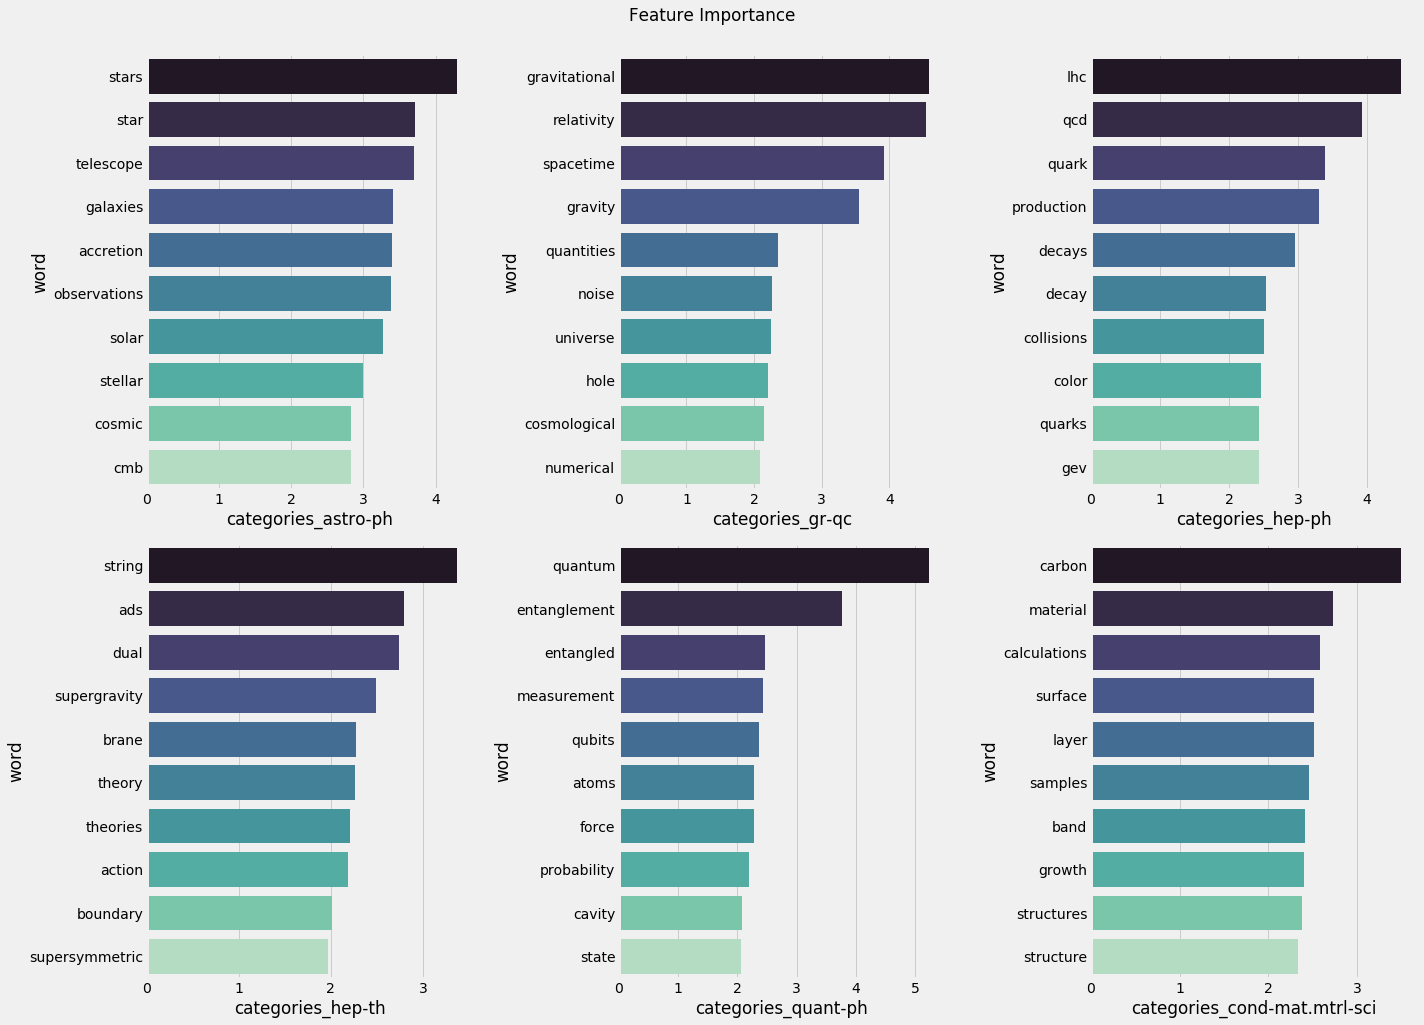

In [79]:
# Assigning the feature names to an empty list
feat_impts = [vect.get_feature_names()]

# For all the models save the feature importances in the list.estimators_ would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())

y_cols = ['categories_astro-ph', 'categories_gr-qc', 'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph', 'categories_cond-mat.mtrl-sci']

# Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns = ['word', 'categories_astro-ph', 'categories_gr-qc',
       'categories_hep-ph', 'categories_hep-th', 'categories_quant-ph', 'categories_cond-mat.mtrl-sci'])
#Converting Feature Importance Columns from string to float
df_feats_impts[y_cols] = df_feats_impts[y_cols].astype("float32")
df_feats_impts.head()

#Creating Individual Feature Importance table by sorting on specific toxic-type column and selecting top 5 words
astro_fi = df_feats_impts[["word","categories_astro-ph"]].sort_values(by = "categories_astro-ph", ascending = False).head(10)
gr_fi = df_feats_impts[["word","categories_gr-qc"]].sort_values(by = "categories_gr-qc", ascending = False).head(10)
hep_ph_fi = df_feats_impts[["word","categories_hep-ph"]].sort_values(by = "categories_hep-ph", ascending = False).head(10)
hep_th_fi = df_feats_impts[["word","categories_hep-th"]].sort_values(by = "categories_hep-th", ascending = False).head(10)
quant_fi = df_feats_impts[["word","categories_quant-ph"]].sort_values(by = "categories_quant-ph", ascending = False).head(10)
math_fi = df_feats_impts[["word","categories_cond-mat.mtrl-sci"]].sort_values(by = "categories_cond-mat.mtrl-sci", ascending = False).head(10)

plt.style.use('fivethirtyeight') 

#Plotting top 5 words based on coefficient values from the LR model
fig,(ax1, ax2) = plt.subplots(2,3,figsize=(20,15))
sns.barplot(x = "categories_astro-ph", y = "word", ax = ax1[0], data = astro_fi,  palette = 'mako')
sns.barplot(x = "categories_gr-qc", y = "word", ax = ax1[1], data = gr_fi, palette = 'mako')
sns.barplot(x = "categories_hep-ph", y = "word", ax = ax1[2], data = hep_ph_fi, palette = 'mako')
sns.barplot(x = "categories_hep-th", y = "word", ax = ax2[0], data = hep_th_fi, palette = 'mako')
sns.barplot(x = "categories_quant-ph", y = "word", ax = ax2[1], data = quant_fi, palette = 'mako')
sns.barplot(x = "categories_cond-mat.mtrl-sci", y = "word", ax = ax2[2], data = math_fi, palette = 'mako')
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
